In [10]:
#### Testing ICP according to the tutorials
#### Non o3d.t version

In [1]:
import numpy as np
import open3d as o3d
import time

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def draw_registration_result(source, target, transformation):
    source_temp = o3d.geometry.PointCloud(source)
    target_temp = o3d.geometry.PointCloud(target)


    source_temp.transform(transformation)

    # This is patched version for tutorial rendering.
    # Use `draw` function for you application.
    o3d.visualization.draw_geometries(
        [source_temp,
         target_temp])

def draw_registration_result_forComparison(source, target, transformation1, transformation2):
    
    source_temp = o3d.geometry.PointCloud(source)
    source_temp.paint_uniform_color((1,0,0))
    
    source_temp2 = o3d.geometry.PointCloud(source)
    source_temp2.paint_uniform_color((0,0,0))    
    target_temp = o3d.geometry.PointCloud(target)
    target_temp.paint_uniform_color((0,1,0))
    

    source_temp.transform(transformation1)
    source_temp2.transform(transformation2)

    # This is patched version for tutorial rendering.
    # Use `draw` function for you application.
    o3d.visualization.draw_geometries(
        [source_temp, source_temp2,
         target_temp])

In [3]:
def gen_volumetric_weld_templates_by_params():
    x_min, x_max = -4.0, 4.0
    y_min, y_max = -12.0, 12.0
    z_min, z_max = -.15, .1
    resolution = 0.3
    stem_x_min, stem_x_max = 1.8, 3.2
    stem_y_min, stem_y_max = -8.0, 8.0
    top_center_y = 7.5
    bottom_center_y = -7.5
    radius = 3.20
    
    def dist(pt1, pt2):
        x1, y1 = pt1
        x2, y2 = pt2
        dx = x2-x1
        dy = y2-y1
        return np.sqrt(dx**2 + dy**2)

    points2 = []
    
    for z in np.arange(z_min, z_max, resolution):
        for x in np.arange(x_min, x_max, resolution):
            for y in np.arange(y_min, y_max, resolution):
                if dist((x,y), (0, top_center_y)) <= radius:
                    points2.append((x,y,z))
                elif dist((x,y), (0, bottom_center_y)) <= radius:
                    points2.append((x,y,z))
                elif stem_x_min<=x<=stem_x_max and stem_y_min<=y<=stem_y_max:
                    points2.append((x,y,z))

    points1 = [(-x, y, z) for x, y, z in points2]
    return {"[": points1, "]": points2}


In [4]:
## Inital PC coords
volumetric_templates = gen_volumetric_weld_templates_by_params()
pts1 = np.array(volumetric_templates["["])

## Creating Secondary PC Coords by Translating init
T = np.identity(4)
T[:, -1] = np.array([10,-10, 20, 1])
pts2 = np.ones((pts1.shape[0], 4))
pts2[:, :-1] = pts1[:, :]
pts2 = (T@pts2.T).T
pts2 = pts2[:, :3]

# 2 separate PC objects
pcdTarget = o3d.geometry.PointCloud()
pcdTarget.points = o3d.utility.Vector3dVector(pts2)
pcdTarget.paint_uniform_color((.5, 0, 0))

pcdTemplate = o3d.geometry.PointCloud()
pcdTemplate.points = o3d.utility.Vector3dVector(pts1)
pcdTemplate.paint_uniform_color((0, 0, 0.5))

PointCloud with 6419 points.

In [5]:
# Search distance for Nearest Neighbour Search [Hybrid-Search is used].
max_correspondence_distance = 10

# Initial alignment or source to target transform.
init_source_to_target = np.identity(4)
init_source_to_target[:, -1] = np.array([9,-11, 20.5, 1])

# Select the `Estimation Method`, and `Robust Kernel` (for outlier-rejection).
# estimation = treg.TransformationEstimationPointToPlane()
estimation = o3d.pipelines.registration.TransformationEstimationPointToPoint()

# Convergence-Criteria for Vanilla ICP
criteria = o3d.pipelines.registration.ICPConvergenceCriteria(relative_fitness=0.000001,
                                       relative_rmse=0.000001,
                                       max_iteration=50)
# Down-sampling voxel-size.
voxel_size = 0.025

# Save iteration wise `fitness`, `inlier_rmse`, etc. to analyse and tune result.
save_loss_log = True

# Example callback_after_iteration lambda function:
callback_after_iteration = lambda updated_result_dict : print("Iteration Index: {}, Fitness: {}, Inlier RMSE: {},".format(
    updated_result_dict["iteration_index"].item(),
    updated_result_dict["fitness"].item(),
    updated_result_dict["inlier_rmse"].item()))


In [6]:
s = time.time()

# registration_icp =  o3d.pipelines.registration.registration_icp(pcdTemplate, pcdTarget, max_correspondence_distance,
#                             init_source_to_target, estimation, criteria,
#                             voxel_size)

registration_icp =  o3d.pipelines.registration.registration_icp(pcdTemplate, pcdTarget, max_correspondence_distance,
                            init_source_to_target)

# registration_icp =  o3d.t.pipelines.registration.icp(pcdTemplate, pcdTarget, max_correspondence_distance,
#                             init_source_to_target, estimation, criteria,
#                             voxel_size, callback_after_iteration)

icp_time = time.time() - s
print("Time taken by ICP: ", icp_time)
print("Inlier Fitness: ", registration_icp.fitness)
print("Inlier RMSE: ", registration_icp.inlier_rmse)

registration_icp

Time taken by ICP:  0.03998970985412598
Inlier Fitness:  1.0
Inlier RMSE:  0.3073505911346135


RegistrationResult with fitness=1.000000e+00, inlier_rmse=3.073506e-01, and correspondence_set size of 6419
Access transformation to get result.

In [7]:
# draw_registration_result(pcdTemplate, pcdTarget, registration_icp.transformation)

In [8]:
draw_registration_result_forComparison(pcdTemplate, pcdTarget, registration_icp.transformation, init_source_to_target)

In [9]:
# a = np.asarray(registration_icp.correspondence_set)

In [10]:
# np.unique(a[:, 0]).size

6419

In [11]:
# np.unique(a[:, 1]).size

3720

In [9]:
## Conclusion
# The non od3.t does not provide as much functionality for registration
#  - namely overriding the convergence criteria, setting a callback function for post iteration

# It took to setting the max_correspondence_difference variable sufficiently high to start seeing some progress
# Visualizing the init transform and final transform show tighter alignment post icp, though not enough
# Levers available as far as I can tell:
#     the template --> perhaps just the circular part
#     need to run on real target just an offseted duplicate template
#     dialing in the max conv diff

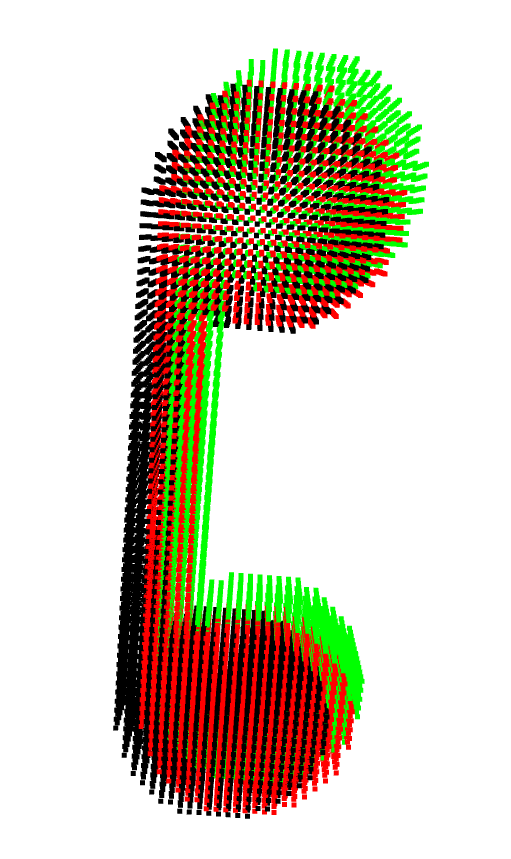
black --> template after init transform; 
red --> template after icp; 
green --> target
